In [1]:
# Importar modulos a emplear
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os

# Definir la ruta base y cargar los datos limpios
base_dir = os.getcwd()
procesados_dir = os.path.join(base_dir, "data", "procesados")

# Importamos el dato limpio

In [2]:
# Cargar los datos limpios
ventas_df = pd.read_csv(os.path.join(procesados_dir, "ventas_limpio.csv"))
productos_df = pd.read_csv(os.path.join(procesados_dir, "productos_limpio.csv"))
ciudad_df = pd.read_csv(os.path.join(procesados_dir, "ciudad_limpio.csv"))

# Union de tablas

In [3]:
# Unir las tablas
# Unir ventas con productos (por Cod_Producto)
ventas_productos = pd.merge(ventas_df, productos_df, on="cod_producto")

# Unir el resultado con ciudad (por Cod_Ciudad)
ventas_completa = pd.merge(ventas_productos, ciudad_df, on="cod_ciudad")

In [4]:
# Calcular ingresos, costos y beneficios
ventas_completa["Ingresos"] = ventas_completa["precio_unitario"] * ventas_completa["unidades_vendidas"]
ventas_completa["Costo_Total"] = (
    (ventas_completa["costo_unitario"] * ventas_completa["unidades_vendidas"])
    + ventas_completa["costo_asociado_al_domicilio"]
)
ventas_completa["Beneficio"] = ventas_completa["Ingresos"] - ventas_completa["Costo_Total"]

# Resumen total
resumen_total = ventas_completa[["Ingresos", "Costo_Total", "Beneficio"]].sum()
print("Resumen Total del Negocio:")
print(resumen_total)

Resumen Total del Negocio:
Ingresos       27635500.0
Costo_Total     5231050.0
Beneficio      22404450.0
dtype: float64


# Graficas

In [5]:
# Gráfico interactivo: Comparación general de ingresos, costos y beneficios
resumen_total_df = resumen_total.reset_index()
resumen_total_df.columns = ["Concepto", "Monto"]

fig = px.bar(
    resumen_total_df,
    x="Concepto",
    y="Monto",
    color="Concepto",
    title="Ingresos vs Costos vs Beneficio (Total)",
    text="Monto",
    labels={"Monto": "Monto ($)", "Concepto": "Concepto"}
)
fig.update_traces(texttemplate="%{text:.2s}", textposition="outside")
fig.update_layout(yaxis_title="Monto ($)", xaxis_title="Concepto")
fig.show()

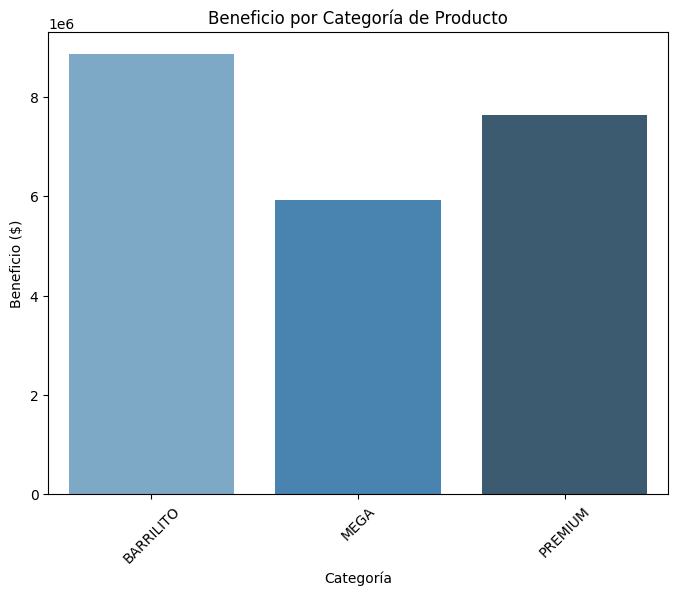

In [10]:
# Beneficio por categoría
beneficio_categoria_df = ventas_completa.groupby("categoria")[["Beneficio"]].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=beneficio_categoria_df, x="categoria", y="Beneficio", palette="Blues_d", hue="categoria", dodge=False)
plt.title("Beneficio por Categoría de Producto")
plt.xlabel("Categoría")
plt.ylabel("Beneficio ($)")
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)  # Quitar la leyenda si no es necesaria
plt.show()

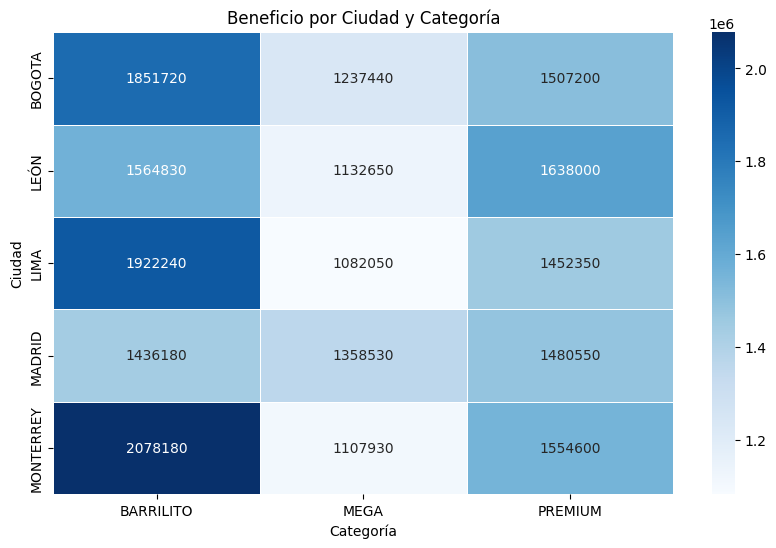

In [11]:
# Beneficio por ciudad y categoría
beneficio_ciudad_categoria = ventas_completa.pivot_table(
    values="Beneficio", index="ciudad", columns="categoria", aggfunc="sum", fill_value=0
)

plt.figure(figsize=(10, 6))
sns.heatmap(beneficio_ciudad_categoria, annot=True, fmt=".0f", cmap="Blues", linewidths=0.5)
plt.title("Beneficio por Ciudad y Categoría")
plt.xlabel("Categoría")
plt.ylabel("Ciudad")
plt.show()

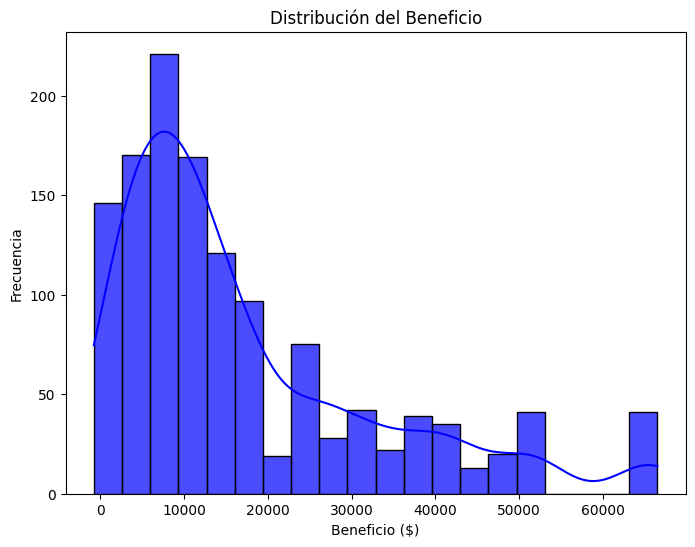

In [12]:
plt.figure(figsize=(8, 6))
sns.histplot(ventas_completa["Beneficio"], bins=20, kde=True, color="blue", alpha=0.7)
plt.title("Distribución del Beneficio")
plt.xlabel("Beneficio ($)")
plt.ylabel("Frecuencia")
plt.show()

In [16]:
# Beneficio por categoría
beneficio_ciudad = ventas_completa.groupby("ciudad")[["Beneficio"]].sum().reset_index()

fig = px.bar(
    beneficio_ciudad.reset_index(),
    x="ciudad",
    y="Beneficio",
    color="ciudad",
    title="Beneficio por Ciudad",
    text="Beneficio",
    labels={"Beneficio": "Beneficio ($)", "Ciudad": "Ciudad"}
)
fig.update_traces(texttemplate="%{text:.2s}", textposition="outside")
fig.update_layout(yaxis_title="Beneficio ($)", xaxis_title="Ciudad")
fig.show()

In [21]:
ventas_completa.columns

Index(['cod_orden', 'cod_producto', 'cod_ciudad', 'unidades_vendidas',
       'fecha_orden', 'tipo_venta', 'nom_producto', 'precio_unitario',
       'categoria', 'costo_unitario', 'ciudad', 'costo_asociado_al_domicilio',
       'Ingresos', 'Costo_Total', 'Beneficio'],
      dtype='object')

In [23]:
# Filtrar datos para excluir beneficios negativos
ventas_filtrada = ventas_completa[ventas_completa["Beneficio"] >= 0]

# Crear el gráfico de dispersión
fig = px.scatter(
    ventas_filtrada,
    x="Ingresos",
    y="Costo_Total",
    size="Beneficio",
    color="ciudad",
    title="Relación entre Ingresos, Costos y Beneficio (sin beneficios negativos)",
    labels={"Ingresos": "Ingresos ($)", "Costo_Total": "Costos Totales ($)"},
    hover_data=["categoria"],
    template="plotly_white",
    size_max=20,
)

fig.update_layout(
    xaxis=dict(title="Ingresos ($)", gridcolor="lightgrey"),
    yaxis=dict(title="Costos Totales ($)", gridcolor="lightgrey"),
    legend_title=dict(text="Ciudad"),
    height=600,
    width=800,
)

fig.show()

In [25]:
# Filtrar transacciones con beneficios negativos
beneficios_negativos = ventas_completa[ventas_completa["Beneficio"] < 0]
beneficios_negativos

,cod_orden,cod_producto,cod_ciudad,unidades_vendidas,fecha_orden,tipo_venta,nom_producto,precio_unitario,categoria,costo_unitario,ciudad,costo_asociado_al_domicilio,Ingresos,Costo_Total,Beneficio
44,5113024,6,1,1,2024-03-03,DOMICILIO,PACIFICO MEGA,2500.0,MEGA,250.0,BOGOTA,3000.0,2500.0,3250.0,-750.0
87,5061468,3,1,1,2024-03-24,TIENDA,VICTORIA,2600.0,BARRILITO,260.0,BOGOTA,3000.0,2600.0,3260.0,-660.0
103,6071738,9,1,1,2024-03-05,DOMICILIO,BUD LG,3000.0,PREMIUM,300.0,BOGOTA,3000.0,3000.0,3300.0,-300.0
501,6884532,3,1,1,2024-01-05,TIENDA,VICTORIA,2600.0,BARRILITO,260.0,BOGOTA,3000.0,2600.0,3260.0,-660.0
528,5094053,3,1,1,2024-01-30,TIENDA,VICTORIA,2600.0,BARRILITO,260.0,BOGOTA,3000.0,2600.0,3260.0,-660.0
608,5353929,3,1,1,2024-01-01,DOMICILIO,VICTORIA,2600.0,BARRILITO,260.0,BOGOTA,3000.0,2600.0,3260.0,-660.0
1000,6851367,9,1,1,2024-02-05,TIENDA,BUD LG,3000.0,PREMIUM,300.0,BOGOTA,3000.0,3000.0,3300.0,-300.0
1010,5592958,3,1,1,2024-03-21,TIENDA,VICTORIA,2600.0,BARRILITO,260.0,BOGOTA,3000.0,2600.0,3260.0,-660.0
1026,6671839,3,1,1,2024-02-19,DOMICILIO,VICTORIA,2600.0,BARRILITO,260.0,BOGOTA,3000.0,2600.0,3260.0,-660.0
1244,6916049,3,1,1,2024-02-20,DOMICILIO,VICTORIA,2600.0,BARRILITO,260.0,BOGOTA,3000.0,2600.0,3260.0,-660.0
